# **Using Physical Attributes and Point Percentages to Predict Position for NBA Players**

##### *Tanisha Amrin, Charmaine Chui, Jakob Sereda, Julian Wright*

## **Introduction**

One of the most popular sports in North America and worldwide (*SportsPro Media*, 2023), basketball has been played by millions, both professional and amateur, since its invention in 1891 (*National Geographic*, 2021). When it comes to professional basketball, all eyes are on the National Basketball Association (or NBA), considered to be the premier professional basketball league in the world (*SportsPro Media*, 2023). 

A key aspect of basketball are the positions of the players. The nuances of these roles can have a profound impact on a team's ability to perform, allowing individual players to show their unique talents if placed in the right role (*RedBull*, 2022). Our goal is to produce a data-driven tool to help categorize players into a position that best suits their body type and skillset.

The question we seek to answer is: **What position is an NBA player most likely to play, given their height, weight, free-throw percentage, and field goal percentage?**

The data set we will use to answer this question was pulled from [*nba.com*](https://www.nba.com/stats/players), the official website of the NBA (*NBA API Client Package, see bibliography*). It contains stats on individual players during each NBA season. There are 58 columns and 4,917 rows in this data set, missing values are represented by "NA". 

In [1]:
# importing libraries 
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(grid)
library(gridExtra)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
# reading in the data from the web
nba_data <- read_csv("https://raw.githubusercontent.com/jakobsereda/dsci-100-project/main/data/stats.csv", show_col_types = FALSE) 

In [3]:
# cleaning and wrangling the data
names(nba_data) <- tolower(names(nba_data))

nba_clean <- nba_data |>
    select(person_id, first_name, last_name, height, weight, position, season_id, 
           gp, gs, min, fg_pct, fg3_pct, ft_pct, reb, ast, stl, blk, tov, pf, pts) |>
    na.omit() |>
    mutate(position = ifelse(position == "Center-Forward", "Center", position)) |>
    mutate(position = ifelse(position == "Guard-Forward", "Guard", position)) |>
    mutate(position = ifelse(position == "Forward-Guard" | position == "Forward-Center", "Forward", position)) |>
    mutate(position = as_factor(position))

In [4]:
set.seed(2024) 

# splitting the data into training and testing sets
nba_split <- initial_split(nba_clean, prop = 3/4, strata = position)

nba_train <- training(nba_split)
nba_test <- testing(nba_split)

head(nba_train)

person_id,first_name,last_name,height,weight,position,season_id,gp,gs,min,fg_pct,fg3_pct,ft_pct,reb,ast,stl,blk,tov,pf,pts
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76003,Kareem,Abdul-Jabbar,86,225,Center,1988-89,74,74,1695,0.475,0.000,0.739,334,74,38,85,95,196,748
201582,Alexis,Ajinca,86,248,Center,2016-17,39,15,584,0.500,0.000,0.725,177,12,20,22,31,77,207
202374,Solomon,Alabi,85,252,Center,2011-12,14,0,122,0.361,0.000,0.875,47,3,2,9,5,11,33
202332,Cole,Aldrich,83,253,Center,2017-18,21,0,49,0.333,0.000,0.333,15,3,2,1,1,11,12
200746,LaMarcus,Aldridge,83,250,Center,2021-22,47,12,1050,0.550,0.304,0.873,258,42,14,47,44,78,607
76021,Chuck,Aleksinas,83,260,Center,1984-85,74,4,1114,0.478,0.000,0.733,270,36,15,15,72,171,377


In [5]:
# summarizing the number of players in each position, and the min, max, and mean of each predictor for each position
nba_summarized <- nba_train |>
    group_by(position) |>
    summarize(min_height = min(height), max_height = max(height), mean_height = mean(height),
              min_weight = min(weight), max_weight = max(weight), mean_weight = mean(weight),
              min_fg_pct = min(fg_pct), max_fg_pct = max(fg_pct), mean_fg_pct = mean(fg_pct),
              min_ft_pct = min(ft_pct), max_ft_pct = max(ft_pct), mean_ft_pct = mean(ft_pct),
              n_players = n())

nba_summarized

position,min_height,max_height,mean_height,min_weight,max_weight,mean_weight,min_fg_pct,max_fg_pct,mean_fg_pct,min_ft_pct,max_ft_pct,mean_ft_pct,n_players
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Forward,71,86,80.11799,153,289,226.2340,0,1,0.4092183,0,1,0.6031200,1017
Center,79,91,83.36118,195,360,250.5577,0,1,0.4317838,0,1,0.5567199,407
Guard,65,84,75.56789,133,255,194.8569,0,1,0.3732541,0,1,0.6561018,1090


In [6]:
set.seed(2024)

# creating recipe and standardizing data
nba_recipe <- recipe(position ~ height + weight + fg_pct + ft_pct, data = nba_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# creating knn-model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform 5 fold cross validation
nba_vfold <- vfold_cv(nba_train, v = 5, strata = position)
gridvals <- tibble(neighbors = c(1:20))

# creating workflow
knn_results <- workflow() |>
    add_recipe(nba_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = nba_vfold, grid = gridvals) |>
    collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7669101,5,0.005924267,Preprocessor1_Model01
1,roc_auc,hand_till,0.8076625,5,0.005675290,Preprocessor1_Model01
2,accuracy,multiclass,0.7661149,5,0.005513226,Preprocessor1_Model02
2,roc_auc,hand_till,0.8645209,5,0.006801193,Preprocessor1_Model02
3,accuracy,multiclass,0.7955432,5,0.010610142,Preprocessor1_Model03
3,roc_auc,hand_till,0.8820122,5,0.010628061,Preprocessor1_Model03
4,accuracy,multiclass,0.7963400,5,0.010994141,Preprocessor1_Model04
4,roc_auc,hand_till,0.8953007,5,0.011577147,Preprocessor1_Model04
5,accuracy,multiclass,0.8074828,5,0.012942764,Preprocessor1_Model05


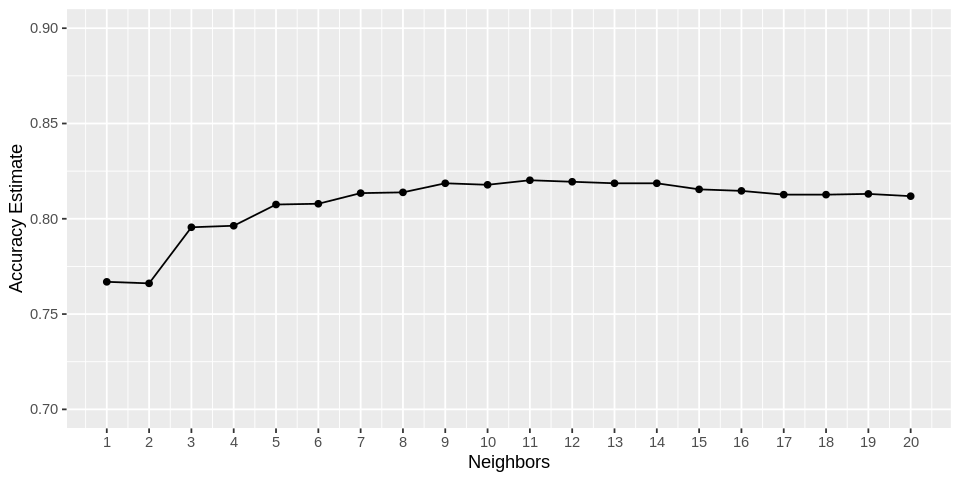

In [7]:
options(repr.plot.width = 8, repr.plot.height = 4)

# filtering for accuracies
accuracies <- knn_results |>
    filter(.metric == "accuracy")

# creating a plot of accuracy vs. k
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.7, 0.9)) # adjusting the y-axis

accuracy_versus_k

In [8]:
# pulling the most accurate k value
best_k <- accuracies |>
    filter(mean == max(mean)) |>
    select(neighbors) |>
    pull()

In [9]:
set.seed(2024)

# creating a new model spec using best k value
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# creating workflow
nba_fit <- workflow() |>
    add_recipe(nba_recipe) |>
    add_model(knn_spec) |>
    fit(data = nba_train)

nba_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1821798
Best kernel: rectangular
Best k: 11

In [10]:
nba_predictions <- predict(nba_fit, nba_test) |>
    bind_cols(nba_test)

nba_metrics <- nba_predictions |>
    metrics(truth = position, estimate = .pred_class) |>
    filter(.metric == "accuracy")

nba_conf_mat <- nba_predictions |>
    conf_mat(truth = position, estimate = .pred_class)

nba_metrics
nba_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8202381


          Truth
Prediction Forward Center Guard
   Forward     275     47    39
   Center       19     89     0
   Guard        46      0   325

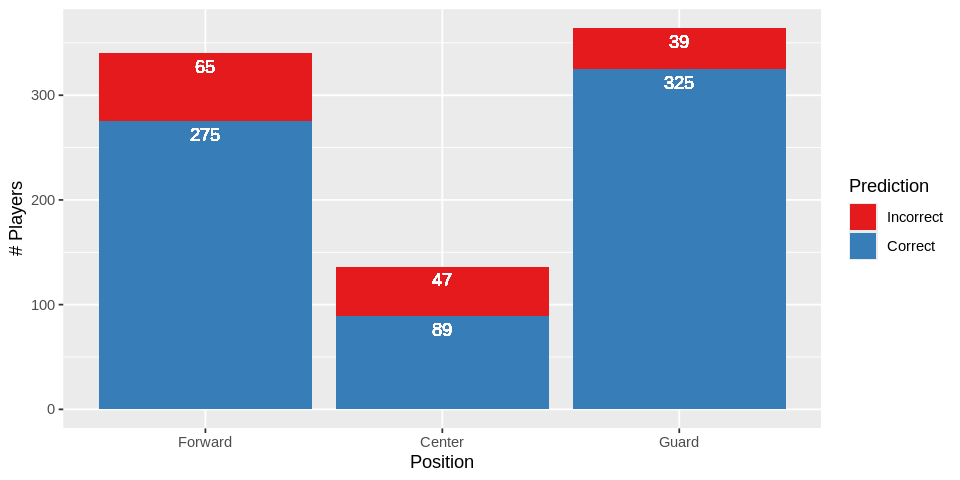

In [11]:
# of actual position, first element guessed as forward, second guessed center, third/last guessed guard
# not sure if we want to do anything with this; delete later if ununsed
forward_conf <- nba_conf_mat[[1]][1:3]
center_conf <- nba_conf_mat[[1]][4:6]
guard_conf <- nba_conf_mat[[1]][7:9]

correct <- tibble(Forward = c(forward_conf[1], sum(forward_conf[2:3])),
                  Center  = c(center_conf[2], center_conf[1] + center_conf[3]),
                  Guard   = c(guard_conf[3], sum(guard_conf[1:2])))

nba_predictions <- nba_predictions |>
  group_by(position) |>
  mutate(label_y = ifelse(.pred_class == position,
                          correct[position][[1]][1],
                          sum(correct[position][[1]])),
         label   = ifelse(.pred_class == position,
                          correct[position][[1]][1],
                          correct[position][[1]][2]))

pred_plot <- nba_predictions |>
    ggplot(aes(x = position, fill = .pred_class == position)) +
    geom_bar() +
    geom_text(aes(y = label_y, label = label), vjust = 1.5, colour = "white") +
    scale_fill_brewer(palette = 'Set1', name = "Prediction", labels = c("Incorrect", "Correct")) +
    labs(x = "Position", y = "# Players")
pred_plot

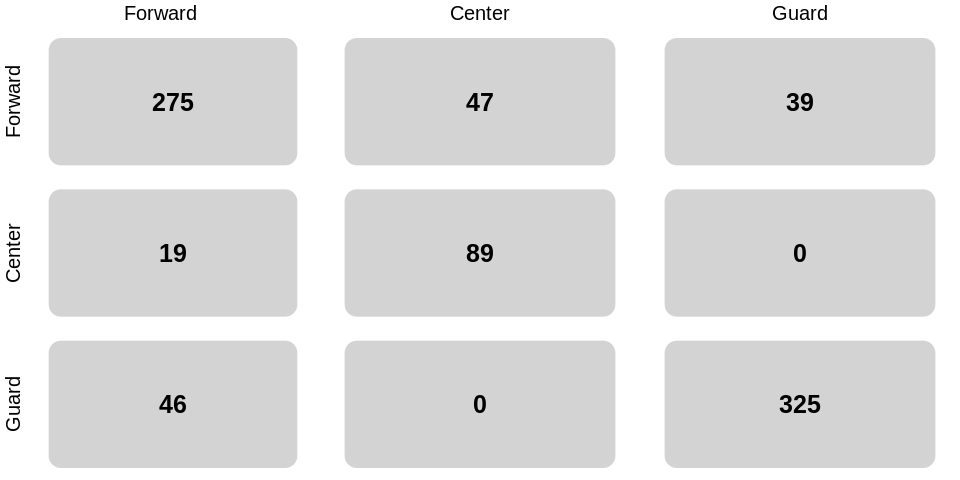

In [12]:
# https://stackoverflow.com/a/45474093
pl = lapply(1:9, function(i) {
    p = grobTree(roundrectGrob(gp = gpar(fill="lightgray", col="white"),
                               width = unit(0.85,"npc"),
                               height = unit(0.85,"npc")),
                 textGrob(nba_conf_mat[[1]][i],
                          gp = gpar(fontsize = 15,
                                    col = "black",
                                    fontface = "bold")))
})

# Create row and column titles
titles <- c("Forward", "Center", "Guard")
col.titles = titles
row.titles = titles

# Add row titles
pl[1:3] = lapply(1:3, function(i) arrangeGrob(pl[[i]], left=row.titles[i]))

# Add column titles and lay out plots
grid.arrange(grobs = lapply(c(1,4,7), function(i) {
  arrangeGrob(grobs = pl[i:(i+2)],
              top = col.titles[i/3 + 1],
              ncol = 1)
}), ncol = 3)